In [51]:
import numpy as np
import pandas as pd
from pathlib import Path

In [52]:
# Configuration
DATA_ROOT   = Path("../csi_dataset")

window_size = 32
stride_size = 16

In [53]:
# Load all files

all_files = list(DATA_ROOT.rglob('*'))
all_files = [p for p in all_files if p.is_file()]
all_files

[PosixPath('../csi_dataset/static/csi_labeled_20260209_164354.csv'),
 PosixPath('../csi_dataset/static/csi_labeled_20260209_164435.csv'),
 PosixPath('../csi_dataset/static/csi_labeled_20260209_164635.csv'),
 PosixPath('../csi_dataset/static/csi_labeled_20260209_164513.csv'),
 PosixPath('../csi_dataset/static/csi_labeled_20260209_164556.csv'),
 PosixPath('../csi_dataset/no_human/csi_labeled_20260209_162733.csv'),
 PosixPath('../csi_dataset/no_human/csi_labeled_20260209_162943.csv'),
 PosixPath('../csi_dataset/no_human/csi_labeled_20260209_162632.csv'),
 PosixPath('../csi_dataset/no_human/csi_labeled_20260209_162543.csv'),
 PosixPath('../csi_dataset/no_human/csi_labeled_20260209_162458.csv'),
 PosixPath('../csi_dataset/movement/csi_labeled_20260209_165528.csv'),
 PosixPath('../csi_dataset/movement/csi_labeled_20260209_165435.csv'),
 PosixPath('../csi_dataset/movement/csi_labeled_20260209_165338.csv'),
 PosixPath('../csi_dataset/movement/csi_labeled_20260209_165613.csv'),
 PosixPath('../c

In [54]:
# Slice one csv file
def slice(df: pd.DataFrame, amp_cols, window_size=window_size, stride_size=stride_size):

    X_raw = df[amp_cols].to_numpy(dtype=np.float32)
    y_raw = df["label"].to_numpy()

    N = len(df)
    X_list, y_list = [], []
    for start in range(0, N - window_size + 1, stride_size):
        end = start + window_size
        X_list.append(X_raw[start:end])
        y_list.append(y_raw[end - 1])
    return np.stack(X_list), np.stack(y_list)

# Denoising functions

def clean_numeric_df(df, feature_cols, q_low=0.001, q_high=0.999):
    """
    กรอง noise แบบเบื้องต้น:
      1. จัดการ Inf → NaN
      2. interpolate / fill NaN
      3. clip outliers ตาม quantile (เช่น 0.1% และ 99.9%)
    """
    df_clean = df.copy()

    # 1) จัดการ Inf
    for col in feature_cols:
        col_data = df_clean[col].values
        col_data = np.where(np.isinf(col_data), np.nan, col_data)
        df_clean[col] = col_data

    # 2) จัดการ NaN – เติมด้วย interpolation + ถ้ายังมี NaN ให้เติม median
    for col in feature_cols:
        series = df_clean[col]

        # ใช้ interpolation ตามลำดับ index
        series = series.interpolate(method="linear", limit_direction="both")

        # ถ้ายังมี NaN ให้ใช้ median ของคอลัมน์นั้น
        if series.isna().any():
            median_val = series.median()
            series = series.fillna(median_val)

        df_clean[col] = series

    # 3) Clip outliers ตาม quantile per column
    for col in feature_cols:
        ql = df_clean[col].quantile(q_low)
        qh = df_clean[col].quantile(q_high)
        df_clean[col] = df_clean[col].clip(ql, qh)

    return df_clean


In [55]:
# Slice all files
X_all, y_all = [], []
for file in all_files:
    df = pd.read_csv(file)

    amp_cols = [c for c in df.columns if c.startswith("amp_")]
    amp_cols = sorted(amp_cols, key=lambda x: int(x.split('_')[1]))

    df = clean_numeric_df(df, feature_cols=amp_cols, q_low=0.001, q_high=0.999)
    X, y = slice(df, amp_cols)
    X_all.append(X)
    y_all.append(y)
X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)

In [56]:
# Class distribution
classes, counts = np.unique(y_all, return_counts=True)
dist = {int(c): int(n) for c, n in zip(classes, counts)}
print("Class distribution:", dist)

Class distribution: {0: 21, 1: 79, 2: 73}


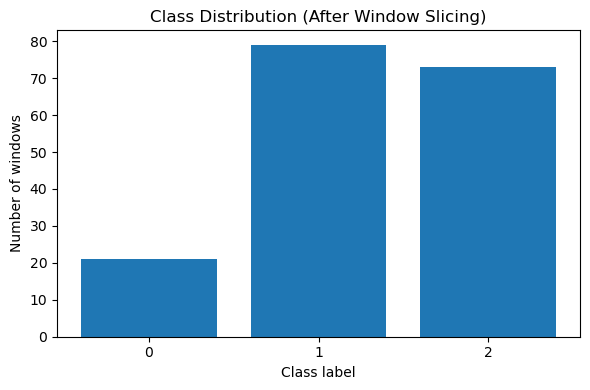

In [49]:
import matplotlib.pyplot as plt

classes, counts = np.unique(y_all, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar([int(c) for c in classes], [int(n) for n in counts])
plt.xticks([int(c) for c in classes])
plt.xlabel("Class label")
plt.ylabel("Number of windows")
plt.title("Class Distribution (After Window Slicing)")
plt.tight_layout()
plt.show()